# streamfunction_vorticity_newton_solver

> A solver based on the Newton's method for the full Navier-Stokes equations in the streamfunction-vorticity form

In [ ]:
#| default_exp streamfunction_vorticity_newton

# Introduction

Integrate in time the vorticity equation.

Run the simple code first.

1. Then change to $Re=10$, $nx=11$, $dt=0.035$, $dpic=0.025$ and $tfinal=0.525$. The plot of the streamfunction should show the numerical instability. Decreasing $dt$ to 0.03 nearly stabilises the result at this $tfinal$, while $dt=0.025$ works to $tfinal=3.0$. This value of $dt$ is the marginal value, but that is for large grids, and small grids are slightly more stable. Best to work at $dt=0.2*Re*h*h$

1. The code first calculates the boundary conditions to first-order, and then extrapolates these results to apply the conditions to second-order. Use this second-order code. Change to  $Re=10$, $nx=11$, $dpic=0.1$ and $tfinal=1.0$ and $dt=0.02$. Find the value of $\omega(x=0.5,y=0.5,t=1.0)$. Now decrease $dt$ to 0.01, 0.005, 0.0025 and 0.001. Then with $nx=15$ try $dt$ = 0.01 (largest stable value), 0.005, 0.0025 and 0.001. Finally with $nx=21$ try $dt=$ 0.005 (largest stable value), 0.0025 and 0.001. Plot these results for $\psi(x=0.5,y=0.5,t=1.0)$ as a function of $dt$. **You could experiment by deleting the lines of the code that apply the boundary conditions at second-order.**

1. Now set $tfinal=3.0$, $dpic=0.1$ and $dt=0.2*Re*h*h$ and obtain $\omega(x=0.5,y=0.5,t)$ to find how long it takes the vorticity to attain a steady value within 4 significant figures. Compare your plots for the steady state of the streamfunction and the vorticity.

1. Gather results for different spatial resolutions $nx$ for the steady horizontal velocity $u$ at the mid-section $x=0.5$, and plot on top of one another.

1. The code calculates the force on the top plate to second-order accuracy. Find the steady force for different spatial resolutions, $nx=11$, 15, 21, 29 and 41. Plot the force as a function of the grid size $h$.

1. Change the top slip boundary condition from $u=\sin^2\pi x$ to $u=1$, i.e change

    $$
    w(i,nx)= -(sin(pi*(i-1)*h)*sin(pi*(i-1)*h)... 
    $$

    to

    $$
    w(i,nx) = -1...
    $$

    Find the force on the top plate for various spatial resolutions, say $nx= 10$, 14, 20, 28 and 40. **Show that the force diverges as the resolution increases as $F = 4.32\ln(1/h) - 3.75$.**

# Imports

In [ ]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from uom_project import core, poisson_solvers, streamfunction_vorticity

import numpy as np
import scipy
from scipy import sparse

In [ ]:
from functools import partial

import matplotlib.pyplot as plt

from fastcore.test import test_eq, test_close

# Newton-Raphson solver

Tries to solve directly for the steady state.

In [ ]:
#| export

# Given the vorticity, solve the Poisson eqn. to find the streamfunction
def get_standard_basis_vector(size, i):
    vec = np.zeros((size, 1))
    vec[i] = 1.0
    
    return vec


def get_jacobian(f, x, Re, kernel_matrix):
    N = int(np.sqrt(x.shape[0] // 2 + 1))
    h = 1 / N

    f_evaluated = f(x=x, Re=Re, kernel_matrix=kernel_matrix)
    
    # Jacobian is sparse
    return sparse.csr_matrix(
        np.hstack([(
            f(
                x=x + h*get_standard_basis_vector(size=x.shape[0], i=i), Re=Re,
                kernel_matrix=kernel_matrix
            ) -
            f_evaluated
        ) for i in range(x.shape[0])])
    )


def f(x, Re, U_wall_top, kernel_matrix):
    N = int(np.sqrt(x.shape[0] // 2 + 1))
    h = 1 / N

    psi = x[:(N-1)**2]
    w_left   = x[(N-1)**2 + 0*(N-1) : (N-1)**2 + 1*(N-1)][:, 0]
    w_right  = x[(N-1)**2 + 1*(N-1) : (N-1)**2 + 2*(N-1)][:, 0]
    w_bottom = x[(N-1)**2 + 2*(N-1) : (N-1)**2 + 3*(N-1)][:, 0]
    w_top    = x[(N-1)**2 + 3*(N-1) : (N-1)**2 + 4*(N-1)][:, 0]
    w_middle = x[(N-1)**2 + 4*(N-1) :]

    # Calculate the equations coming from the Poisson equation
    f_poisson = kernel_matrix @ psi
    f_poisson = f_poisson + h ** 2 * w_middle

    psi = psi.reshape(N-1, N-1)

    # Calculate contributions coming from the vorticity transport equation
    w_middle = w_middle.reshape(N-1, N-1)
    
    # Calculate the sides first
    # y = 0, U_wall = 0
    f_w_bottom = h ** 2 * (w_middle[:, 0] + 3 * w_bottom) + 8 * psi[:, 0]
    # y = 1, U_wall is known here
    f_w_top = h ** 2 * (w_middle[:, -1] + 3 * w_top) + 8 * (
        h * U_wall_top + psi[:, -1]
    )
    # x = 0
    f_w_left = h ** 2 * (w_middle[0, :] + 3 * w_left) + 8 * psi[0, :]
    # x = 1
    f_w_right = h ** 2 * (w_middle[-1, :] + 3 * w_right) + 8 * psi[-1, :]

    f_w_middle = -4 * w_middle
    f_w_middle[:-1, :] += w_middle[1:, :]
    f_w_middle[-1:, :] += w_right
    f_w_middle[1:, :] += w_middle[:-1, :]
    f_w_middle[:1, :] += w_left
    f_w_middle[:, :-1] += w_middle[:, 1:]
    f_w_middle[:, -1] += w_top
    f_w_middle[:, 1:] += w_middle[:, :-1]
    f_w_middle[:, 0] += w_bottom

    f_w_middle[1:-1, 1:-1] += Re * (
        (psi[2:, 1:-1] - psi[:-2, 1:-1]) * (w_middle[1:-1, 2:] - w_middle[1:-1, :-2]) -
        (psi[1:-1, 2:] - psi[1:-1, :-2]) * (w_middle[2:, 1:-1] - w_middle[:-2, 1:-1])
    ) / 4
    f_w_middle[:1, 1:-1] += Re * (
        psi[1, 1:-1] * (w_middle[0, 2:] - w_middle[0, :-2]) -
        (psi[0, 2:] - psi[0, :-2]) * (w_middle[1, 1:-1] - w_left[1:-1])
    ) / 4
    f_w_middle[-1:, 1:-1] -= Re * (
        psi[-2, 1:-1] * (w_middle[-1, 2:] - w_middle[-1, :-2]) +
        (psi[-1, 2:] - psi[-1, :-2]) * (w_right[1:-1] - w_middle[-2, 1:-1])
    ) / 4
    f_w_middle[1:-1, 0] += Re * (
        (psi[2:, 0] - psi[:-2, 0]) * (w_middle[1:-1, 1] - w_bottom[1:-1]) -
        psi[1:-1, 1] * (w_middle[2:, 0] - w_middle[:-2, 0])
    ) / 4
    f_w_middle[1:-1, -1] += Re * (
        (psi[2:, -1] - psi[:-2, -1]) * (w_top[1:-1] - w_middle[1:-1, -2]) +
        psi[1:-1, -2] * (w_middle[2:, -1] - w_middle[:-2, -1])
    ) / 4
    f_w_middle[0, 0] += Re * (
        psi[1, 0] * (w_middle[0, 1] - w_bottom[0]) -
        psi[0, 1] * (w_middle[1, 0] - w_left[0])
    ) / 4
    f_w_middle[-1, 0] -= Re * (
        psi[-2, 0] * (w_middle[-1, 1] - w_bottom[-1]) +
        psi[-1, 1] * (w_right[0] - w_middle[-2, 0])
    ) / 4
    f_w_middle[0, -1] += Re * (
        psi[1, -1] * (w_top[0] - w_middle[0, -2]) +
        psi[0, -2] * (w_middle[1, -1] - w_left[-1])
    ) / 4
    f_w_middle[-1, -1] -= Re * (
        psi[-2, -1] * (w_top[-1] - w_middle[-1, -2]) -
        psi[-1, -2] * (w_right[-1] - w_middle[-2, -1])
    ) / 4

    return np.concatenate([
        f_poisson[:, 0], f_w_left, f_w_right, f_w_bottom, f_w_top, f_w_middle.flatten()
    ], axis=0).reshape(-1, 1)


def reconstruct_w(w_tmp, N):
    w = np.zeros((N+1, N+1))
    
    w[:1, 1:-1] = w_tmp[0*(N-1):1*(N-1)].T
    w[-1:, 1:-1] = w_tmp[1*(N-1):2*(N-1)].T
    w[1:-1, :1] = w_tmp[2*(N-1):3*(N-1)]
    w[1:-1, -1:] = w_tmp[3*(N-1):4*(N-1)]
    w[1:-1, 1:-1] = w_tmp[4*(N-1):].reshape((N - 1, N - 1))
    
    return w


def newton_iterator(
    f, get_jacobian, N, Re,
    algorithm="base", TOL=1e-8, max_iter=10, quiet=True
):
    '''
        - f: evaluates the function given x, Re
        - get_jacobian: evaluates the Jacobian given N, h
        - N: number of grid points
        - h: grid size
        - Re: Reynolds number
    '''

    h = 1 / N

    n_iter = 0 # number of iterations

    # Initialization
    # Size (N - 1) ** 2         + (N + 1) ** 2    - 4
    # Size (for streamfunction) + (for vorticity) - (corners of vorticity)
    x = np.zeros(((N - 1) ** 2 + (N + 1) ** 2 - 4, 1))
    A = poisson_solvers.construct_laplacian_kernel_matrix(N=N-1, h=1)
    f_current = f(x=x, Re=Re, kernel_matrix=A)
    
    # Check if the initial guess is a solution
    f_norm = scipy.linalg.norm(f_current)
    if f_norm <= TOL:
        if not quiet:
            print(f"n_iter={n_iter}")

        return x, n_iter
    
    while n_iter < max_iter:
        n_iter += 1
        jacobian = get_jacobian(f=f, x=x, Re=Re, kernel_matrix=A)

        kwargs = {}
        if algorithm == "bicgstab": kwargs["tol"] = 1e-6
        dx = core.solve_sparse_linear_system(
            A=jacobian, b=-h * f_current, algorithm=algorithm, **kwargs
        ).reshape((-1, 1))
        x_next = x + dx
        
        f_current = f(x=x_next, Re=Re, kernel_matrix=A)
        
        f_norm = scipy.linalg.norm(f_current)
        if not quiet:
            print(f"iter={n_iter}; residual={f_norm}; dx={scipy.linalg.norm(dx)}")
        if f_norm <= TOL:
            break
        
        x = x_next
        
    if not quiet:
        print(f"n_iter={n_iter}")
    
    return x_next, n_iter


In [ ]:
#| export
def newton_solver(
    f, get_jacobian, N, Re,
    algorithm="base", TOL=1e-8, max_iter=10, quiet=True
):
    assert algorithm != "cg", (
        "Linear system is not positive definite, cg algorithm cannot be used"
    )

    # Initialization
    # Size (N - 1) ** 2 (for streamfunction) + (N + 1) ** 2 (for vorticity) - 4 (corners of vorticity)
    x0 = np.zeros(((N - 1) ** 2 + (N + 1) ** 2 - 4, 1))

    solution, n_iter = newton_iterator(
        f=f, get_jacobian=get_jacobian, N=N, Re=Re,
        algorithm=algorithm,
        TOL=TOL, max_iter=max_iter, quiet=quiet
    )
    
    psi, w = solution[:(N - 1) ** 2], solution[(N - 1) ** 2:]
    
    # Get final psi
    psi = psi.reshape(N - 1, N - 1)
    psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    # Get final w
    w = reconstruct_w(w_tmp=w, N=N)
    w = w.reshape(N + 1, N + 1)
    
    return w, psi, n_iter


Test for Re = 0:

In [ ]:
N = 20
Re = 0 # i.e. viscosity mu = inf
U_wall_top = np.sin(np.pi * np.arange(1, N) / N) ** 2

w, psi, n_iter = newton_solver(
    f=partial(f, U_wall_top=U_wall_top),
    get_jacobian=get_jacobian, N=N, Re=Re, quiet=False,
)
test_eq(np.any(w), True)
test_eq(np.any(psi), True)
test_eq(n_iter, 1)

iter=1; residual=2.914118169851718e-14; dx=39.71450891546215
n_iter=1


In [ ]:
N = 20
Re = 10 # i.e. viscosity mu = 0.1
U_wall_top = np.sin(np.pi * np.arange(1, N) / N) ** 2

w, psi, n_iter = newton_solver(
    f=partial(f, U_wall_top=U_wall_top),
    get_jacobian=get_jacobian, N=N, Re=Re, quiet=False
)
test_eq(np.any(w), True)
test_eq(np.any(psi), True)
test_eq(n_iter, 3)

iter=1; residual=1.083638166644002; dx=39.71450891546215
iter=2; residual=0.001540492931316756; dx=2.273926820301316
iter=3; residual=8.799678364852772e-10; dx=0.001464259783746122
n_iter=3


# Profiling

In [ ]:
# N = 50
# Re = 10 # i.e. viscosity mu = 0.1

# %prun newton_solver(N=N, Re=Re, quiet=True)

# Initialization

In [ ]:
%%time

# We'll only need most of these later
N = 20
nx, ny, x_grid, y_grid = core.setup_poisson_problem(N=N)[2:]
h = 1 / N

U_wall_top = np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2

dpic = 0.5
Re = 10 # i.e. mu = 0.1
tfinal = 3.5
dt = 0.2 * Re / (N ** 2)

w, psi, _ = newton_solver(
    f=partial(f, U_wall_top=U_wall_top),
    get_jacobian=get_jacobian, N=N, Re=Re, quiet=False,
)
w2, psi2 = streamfunction_vorticity.streamfunction_vorticity_iterative_solver(
    N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top, dt=dt, print_every=dpic,
)[:2]

test_eq(np.allclose(w, w2), True)
test_eq(np.allclose(psi, psi2), True)
test_close(w, w2, eps=1e-7)
test_close(psi, psi2, eps=1e-8)

iter=1; residual=0.636435003205167; dx=75.32418094109138
iter=2; residual=0.0008124440101378658; dx=4.063778788259962
iter=3; residual=5.180535329409514e-10; dx=0.002844163864972045
n_iter=3
t=0.50000; w(0.5, 0.5)=-0.5318425795976052
t=1.00000; w(0.5, 0.5)=-0.6392078531937391
t=1.50000; w(0.5, 0.5)=-0.6470209335147179
t=2.00000; w(0.5, 0.5)=-0.6475875194638528
t=2.50000; w(0.5, 0.5)=-0.6476286124379771
t=3.00000; w(0.5, 0.5)=-0.6476315928957446
t=3.50000; w(0.5, 0.5)=-0.6476318090684624
CPU times: user 16.5 s, sys: 601 ms, total: 17.1 s
Wall time: 19.4 s


# Speeds

In [ ]:
# %%time

# # N_values = [10, 20, 40, 50, 70, 100]
# N_values = [10, 20, 40]
# Re = 10 # i.e. mu = 0.1

# tfinal = 3.5

# with open("logs/speeds.csv", "wt") as file:
#     file.write("N,newton,iterative\n")
#     for N in N_values:
#         print(f"N={N}")
#         file.write(f"{N},")

#         U_wall_top = np.sin(np.pi * np.arange(1, N) / N) ** 2
#         w, psi, n_iter = newton_solver(
#             f=partial(f, U_wall_top=U_wall_top),
#             get_jacobian=get_jacobian, N=N, Re=Re
#         )
#         print(f"Newton converged in {n_iter} iterations")

#         w2, psi2 = streamfunction_vorticity.streamfunction_vorticity_iterative_solver(
#             N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top,
#         )[:2]

#         assert np.allclose(w, w2) and np.allclose(psi, psi2)

#         f_tmp = partial(f, U_wall_top=U_wall_top)
#         time = %timeit -o -q -n 1 -r 1 newton_solver(f=f_tmp, get_jacobian=get_jacobian, N=N, Re=Re)
#         print(time.average, time.stdev)
#         file.write(f"{time.average},")

#         time = %timeit -o -q -n 1 -r 1 streamfunction_vorticity.streamfunction_vorticity_iterative_solver(N=N, Re=Re, tfinal=tfinal, U_wall_top=U_wall_top)
#         print(time.average, time.stdev)
#         file.write(f"{time.average}\n")

#         print()

# Exercise 6

10
14
20
28
40


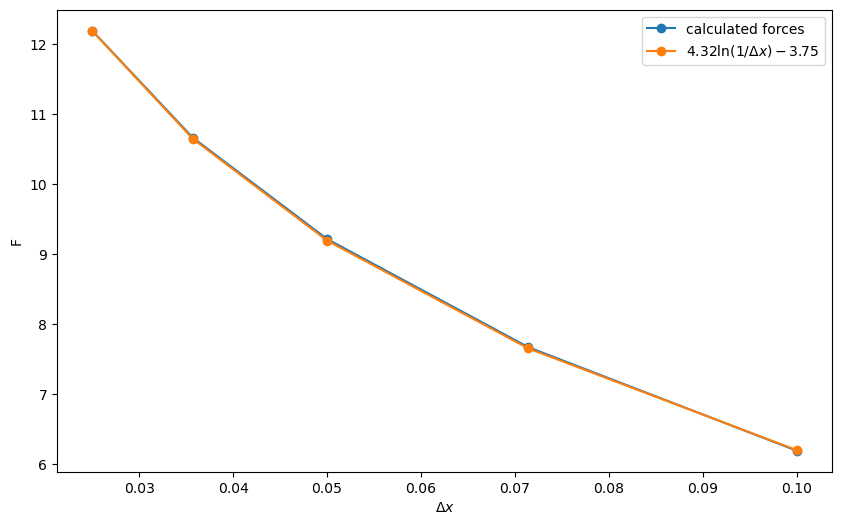

CPU times: user 4.69 s, sys: 185 ms, total: 4.88 s
Wall time: 6.51 s


In [ ]:
%%time

Re = 10 # i.e. mu = 0.1
U_wall_top = 1.0

N_values = np.array([10, 14, 20, 28, 40])
forces = []
for N in N_values:
    print(N)
    w, psi, _ = newton_solver(
        f=partial(f, U_wall_top=U_wall_top),
        get_jacobian=get_jacobian, N=N, Re=Re
    )
    
    force = core.calculate_force(psi)
    forces.append(force)
    

plt.figure(figsize=(10, 6))
plt.plot(1 / N_values, forces, marker="o", label="calculated forces")
plt.plot(1 / N_values, 4.32 * np.log(N_values) - 3.75, marker="o", label=r"$4.32\ln(1/\Delta x) - 3.75$")
plt.xlabel(r"$\Delta x$")
plt.ylabel("F")
plt.legend()

plt.show()

# Calculating the flow

In [ ]:
%%time

N = 40
Re = 10 # i.e. mu = 0.1

# We'll only need these later
nx, ny, x_grid, y_grid = core.setup_poisson_problem(N=N)[2:]
h = 1 / N
U_wall_top = np.sin(np.pi * np.arange(1, nx - 1) * h) ** 2

w, psi, _ = newton_solver(
    f=partial(f, U_wall_top=U_wall_top),
    get_jacobian=get_jacobian, N=N, Re=Re
)

CPU times: user 2.66 s, sys: 87.3 ms, total: 2.75 s
Wall time: 3.94 s


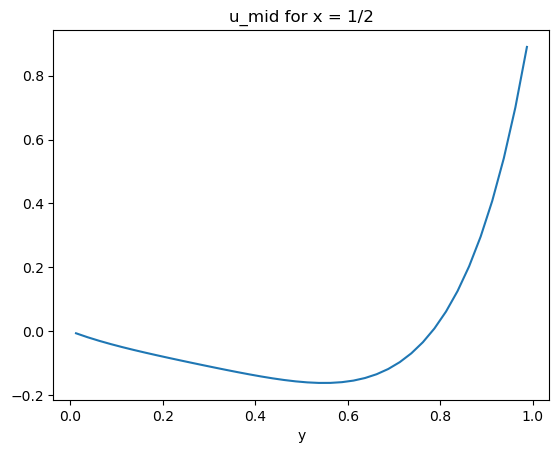

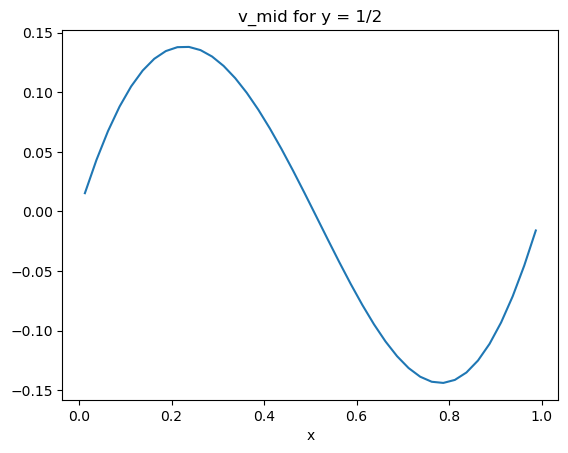

In [ ]:
i = nx // 2
u_mid = (psi[i, 1:] - psi[i, :-1]) / h
plt.plot(y_grid[i, :-1] + h / 2, u_mid)
plt.title("u_mid for x = 1/2")
plt.xlabel("y");
plt.show()

j = ny // 2
v_mid = -(psi[1:, j] - psi[:-1, j]) / h
plt.plot(x_grid[:-1, j] + h / 2, v_mid)
plt.title("v_mid for y = 1/2")
plt.xlabel("x");
plt.show()

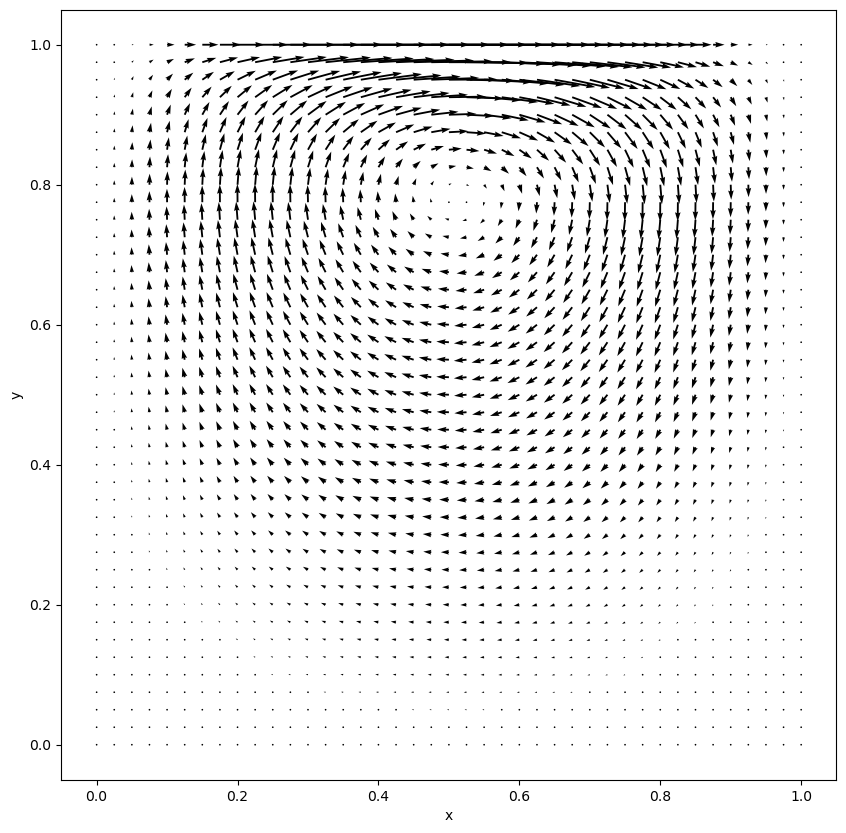

In [ ]:
# See this: https://www.youtube.com/watch?v=BQLvNLgMTQE
u, v = core.calculate_velocity(psi=psi)

test_eq(
    np.allclose(u[:, -1], np.sin(np.pi * np.arange(psi.shape[0]) * h) ** 2),
    True
)
test_eq(np.all(u[0, :] == 0), True)
test_eq(np.all(u[:, 0] == 0), True)
test_eq(np.all(u[-1, :] == 0), True)

test_eq(np.all(v[0, :] == 0), True)
test_eq(np.all(v[:, 0] == 0), True)
test_eq(np.all(v[-1, :] == 0), True)
test_eq(np.all(v[:, -1] == 0), True)

plt.figure(figsize=(10, 10))

plt.quiver(x_grid, y_grid, u, v)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

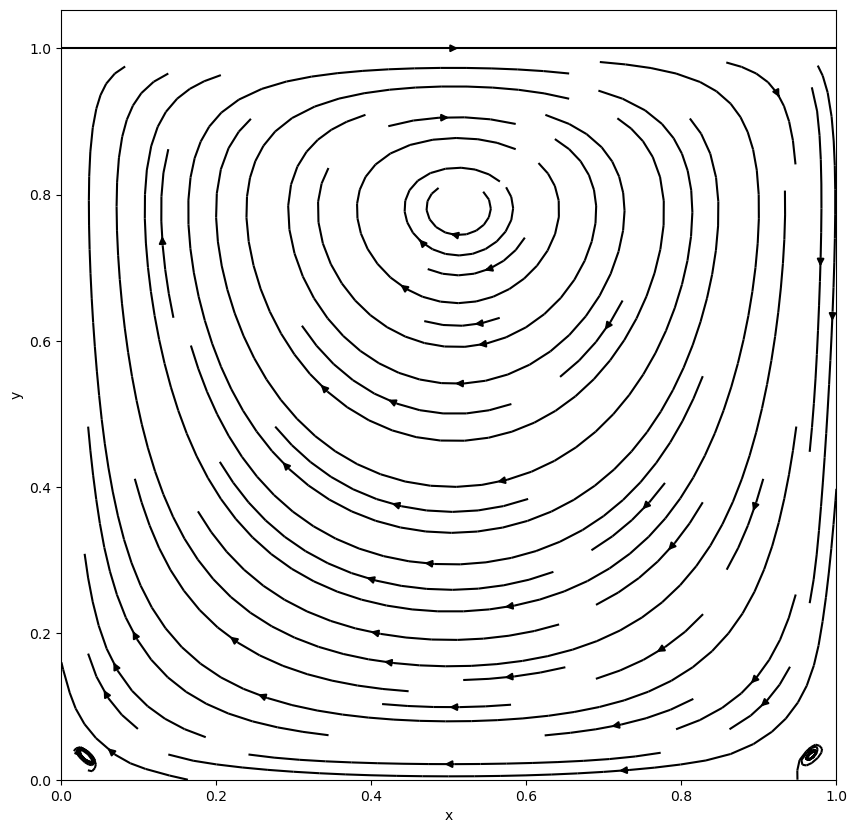

In [ ]:
# See this: https://www.youtube.com/watch?v=BQLvNLgMTQE
u, v = core.calculate_velocity(psi=psi)

plt.figure(figsize=(10, 10))

plt.streamplot(x_grid.T, y_grid.T, u.T, v.T, color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
xyuv = np.vstack([
    x_grid.flatten(), y_grid.flatten(), u.flatten(), v.flatten(),
]).T
print(xyuv.shape)

# np.savetxt('data/vorticity/flow_field.txt', xyuv, delimiter=' ', fmt=['%.8f', '%.8f', '%.18f', '%.18f'])

(1681, 4)


# Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()